# Курсовая работа № 2
## Аналитика. Начальный уровень


## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомендаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import re

In [2]:
import requests
from datetime import datetime
import itertools
import json

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [3]:
# Определим несколько функций для работы с датами
def get_date(x):
    if isinstance(x, datetime):
        return x.date()
    else:
        return x

def get_year(x):
    return x.year

In [4]:
sns.set_style('darkgrid')

In [5]:
mpl.rc('font', size=12)
mpl.rcParams['figure.figsize'] = (10.0, 7.0)

## Содержание 
Мне было интересно посмотреть, как изменилась вовлеченность паблика Skillbox после начала пандемии Covid-19, одним из последствий которой стало увеличение спроса на онлайн-обучение и удаленную работу. Поэтому я решила выгрузить посты со стены паблика за последние 3-4 года, а за начало пандемии принять январь 2020 года.\
При попытке собрать данные в датасет, выяснилось, что подсчет количества просмотров стал вестись в паблике с января 2017 года - этим в итоге был обусловлен выбор нижней временной границы. В качестве верхней границы я выбрала июль 2021: мне не хотелось брать в расчет посты за последние два месяца, ведь статистика для них может значительно изменяться до сих пор. В итоге было решено проводить анализ постов за период `2017-01-01 - 2021-06-30` включительно, т.е. за 4,5 года: 3 года до пандемии, 1.5 года после ее начала.

- [Выгрузка постов](#Выгрузка-постов), сохранение и загрузка датафрейма из [csv-файла](#Сохранение)
- [Влияние пандемии на вовлеченность пользователей](#Влияние-пандемии-на-вовлеченность-пользователей)
- [Предпочтительное время публикации](#Предпочтительное-время-публикации)
- [Предпочтительные дни публикации](#Предпочтительные-дни-публикации)
- [Направления и рубрики паблика](#Направления-и-рубрики-паблика): 
    - [Популярность направлений в 2020 и 2021 году](#Популярность-направлений-в-2020-и-2021-году)
    - [Анализ рубрик](#Анализ-рубрик)

## Выгрузка постов

In [6]:
vk_token = '47b39306a44ef13d16afa44ef7b073c33d8359efe71d794efa2be51155f818690ce52d7ceb21d4a8b00e2'

Загрузим данные о публикациях и составим датафрейм со следующими колонками:
   - дата и время поста, 
   - текст поста, 
   - количество просмотров, 
   - количество лайков, 
   - количество комментариев,
   - количество репостов,
   - количество голосов в опросе, если он есть.


In [7]:
%%time

# начальная дата и значение сдвига
date = datetime.today()
offset = 0

# пустые списки для соответствующих колонок в датафрейме
dates = []
texts = []
comments = []
likes = []
reposts = []
views = []
votes = []

# список, содержащий информацию по каждому запрошенному посту
raw_posts_info = []

while date > pd.Timestamp('2017-01-01'):
    url = 'https://api.vk.com/method/wall.get?access_token=' + vk_token + f'&owner_id=-66669811&offset={offset}&count=100&v=5.92'
    response = getjson(url)
    offset += 100
    date = datetime.fromtimestamp(response['response']['items'][-1]['date'])
    raw_posts_info = raw_posts_info.extend(response['response']['items'])
    for post in response['response']['items']:
        dates.append(post['date'])
        comments.append(post['comments']['count'])
        likes.append(post['likes']['count'])
        reposts.append(post['reposts']['count'])
        if post.get('views', False):
            views.append(post['views']['count'])
        else:
            views.append(None)
        if post.get('copy_history', False):
            texts.append(post['text'] + post['copy_history'][0]['text'])
        else:
            texts.append(post['text'])
        poll_num = None
        if post.get('attachments', False):
            poll_num = False
            for i, att in enumerate(post['attachments']):
                if att.get('poll', False):
                    poll_num = i
            if poll_num:    
                votes.append(post['attachments'][poll_num]['poll']['votes'])
            else:
                votes.append(None)
        else:
            votes.append(None)
            
all_posts_df = pd.DataFrame({'date_and_time': dates, 'text': texts, 'views': views, 'likes': likes, 'comments': comments, 
                         'reposts': reposts, 'votes': votes})

# приведение даты к формату datetime
all_posts_df.date_and_time = all_posts_df.date_and_time.apply(datetime.fromtimestamp)

# получившийся датафрейм
all_posts_df.head()


Wall time: 24.3 s


,date_and_time,text,views,likes,comments,reposts,votes
0,2021-08-19 12:36:02,"Нет, это не шутка! Попробовать 34 курса и инте...",52094.0,429,95,798,NaN
1,2021-09-12 10:59:31,Кто из нас хоть раз в жизни не окунулся в этот...,4239.0,16,1,4,NaN
2,2021-09-11 11:20:33,"Никак не можете определиться, какой второй язы...",10653.0,18,4,10,NaN
3,2021-09-09 17:02:31,Женщины в России зарабатывают в среднем на 28%...,15506.0,46,65,25,NaN
4,2021-09-08 14:05:05,"У вас когда-нибудь было ощущение, что жизнь ид...",15685.0,22,4,16,NaN


In [8]:
# выберем интересующий нас промежуток времени и сохраним его в отедльный датафрейм
posts_df = all_posts_df[(datetime(2017, 1, 1) <= all_posts_df.date_and_time) 
                        & (all_posts_df.date_and_time < datetime(2021, 7, 1))].copy()
posts_df.head()

,date_and_time,text,views,likes,comments,reposts,votes
152,2021-06-30 18:19:40,"Если вы опустили руки, повесили нос и упали ду...",67356.0,31,19,15,NaN
153,2021-06-30 15:30:29,Часто люди работают как лампочки: либо по щелч...,15997.0,34,15,9,NaN
154,2021-06-30 13:28:07,"Получите шанс на сотрудничество со Skillbox, P...",14333.0,17,0,3,NaN
155,2021-06-29 20:29:56,Можно ли получить высшее образование полностью...,15252.0,36,11,22,NaN
156,2021-06-29 18:56:23,Не учитесь на чужих ошибках — учитесь на чужих...,13554.0,19,0,4,NaN


#### Сохранение
Сохраним датафрейм и список, содержащий необработанную информацию по всем постам, в файлы `posts.csv` и `raw_posts_info.json`, чтобы при каждом запуске ноутбука не приходилось обновлять access_token и заново делать запросы к API Вконтакте.

In [9]:
posts_df.to_csv('posts.csv', na_rep='NaN')

In [10]:
with open('raw_posts_info.json', 'w') as file:
    json.dump(raw_posts_info, file, indent=4) 

Загрузим датафрейм из файла `posts.csv` и список ответов на запросы из `raw_posts_info.json`:

In [11]:
posts_df = pd.read_csv('posts.csv', parse_dates=['date_and_time'], index_col=0, na_values='NaN', keep_default_na=False)

In [12]:
with open('raw_posts_info.json', 'r') as file:
    raw_posts_info = json.load(file)

In [13]:
posts_df.head()

,date_and_time,text,views,likes,comments,reposts,votes
152,2021-06-30 18:19:40,"Если вы опустили руки, повесили нос и упали ду...",67356.0,31,19,15,NaN
153,2021-06-30 15:30:29,Часто люди работают как лампочки: либо по щелч...,15997.0,34,15,9,NaN
154,2021-06-30 13:28:07,"Получите шанс на сотрудничество со Skillbox, P...",14333.0,17,0,3,NaN
155,2021-06-29 20:29:56,Можно ли получить высшее образование полностью...,15252.0,36,11,22,NaN
156,2021-06-29 18:56:23,Не учитесь на чужих ошибках — учитесь на чужих...,13554.0,19,0,4,NaN


## Влияние пандемии на вовлеченность пользователей

Чтобы оценить влияние пандемии на вовлеченность пользователей, попробуем для начала построить график зависимости просмотров от времени:

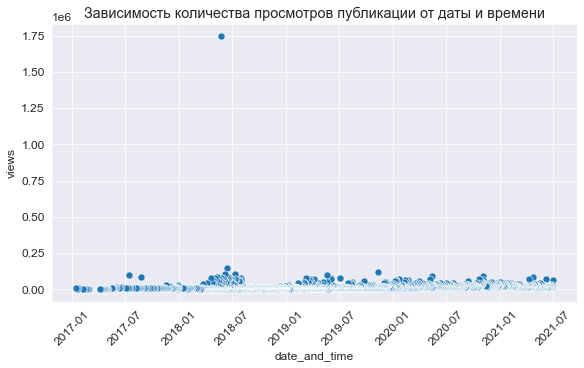

In [14]:
plt.figure(figsize=(8, 5), constrained_layout=True)
sns.scatterplot(data=posts_df, x='date_and_time', y='views', s=50)
plt.title('Зависимость количества просмотров публикации от даты и времени')
plt.tick_params(axis='x', rotation=45)
plt.show()

В рамках выбранного периода есть пост, у которого просмотров значительно больше, чем у всех остальных. Посмотрим, что это за пост:

In [15]:
posts_df.sort_values(by='views').tail(1)

,date_and_time,text,views,likes,comments,reposts,votes
2904,2018-05-23 16:00:11,"Хей-хей, ребята. Мы тут с Лентачом запустили с...",1744088.0,919,7,18,NaN


In [16]:
# текст поста
posts_df.sort_values(by='views').tail(1).text.values[0]

'Хей-хей, ребята. Мы тут с Лентачом запустили спецпроект, который поможет понять, кто вы в мире Digital. \n \nДа, это тест, но он сделан только из emoji, так что вероятность ошибки в нем — всего 1%! Врывайтесь — https://vk.cc/85VVQ8 — и делитесь результатами с друзьями и в комментариях!\n\n#test@skillbox_education'

Большое количество просмотров может быть связано с тем, что этот пост - коллаборация с другим крупным пабликом Вконтакте или же с тем, что проект сам по себе оказался очень удачным. Мы не будем удалять пост из датасета, просто установим меньший лимит по оси *y*, а время публикации поста отметим пунктирной линией. Попробуем оценить, повлиял ли пост с совместным тестом от Лентача на количество просмотров последующих публикаций в паблике.

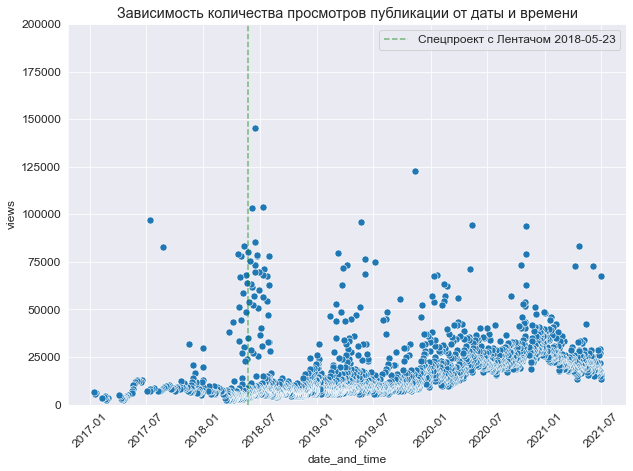

In [17]:
sns.scatterplot(data=posts_df, x='date_and_time', y='views', s=50)
plt.title('Зависимость количества просмотров публикации от даты и времени')
plt.ylim(0, 200000)
plt.tick_params(axis='x', rotation=45)
plt.axvline(posts_df.sort_values(by='views').tail(1).date_and_time.values[0], c='g', ls='--', alpha=0.5, 
            label='Спецпроект с Лентачом 2018-05-23')
plt.legend()
plt.show()

Можно заметить, что до 2018 года постов с количеством просмотров более 25 000 было всего несколько. Таких постов стало больше еще до публикации поста с совместным тестом от Лентача. Хотя после этого поста появилось несколько публикаций с количеством просмотров более 100 000, нельзя сказать, что коллаб с Лентачом очень сильно повлиял на рост просмотров последующих публикаций. 


По графику видно, что с началом 2020 года "линия" просмотров публикаций поднимается, но чтобы сделать внятный вывод относительно влияния пандемии на этот рост, нужна более наглядная визуализация. Поэтому построим график зависимости медианы количества просмотров по месяцам от времени, а также посмотрим, как изменялось количество публикаций в месяц и влияет ли частота публикаций на вовлеченность пользователей. Для этого добавим колонку, содержащую год и месяц, когда был размещен соответствующий пост.

In [18]:
from datetime import date
posts_df['month'] = [date(x.year, x.month, 1) for x in posts_df.date_and_time]
posts_df.head()

,date_and_time,text,views,likes,comments,reposts,votes,month
152,2021-06-30 18:19:40,"Если вы опустили руки, повесили нос и упали ду...",67356.0,31,19,15,NaN,2021-06-01
153,2021-06-30 15:30:29,Часто люди работают как лампочки: либо по щелч...,15997.0,34,15,9,NaN,2021-06-01
154,2021-06-30 13:28:07,"Получите шанс на сотрудничество со Skillbox, P...",14333.0,17,0,3,NaN,2021-06-01
155,2021-06-29 20:29:56,Можно ли получить высшее образование полностью...,15252.0,36,11,22,NaN,2021-06-01
156,2021-06-29 18:56:23,Не учитесь на чужих ошибках — учитесь на чужих...,13554.0,19,0,4,NaN,2021-06-01


In [19]:
# сгруппируем данные по месяцам и найдем медианы количества просмотров, лайков, комментариев и репостов
metrics_by_mon = posts_df.groupby('month')[['views', 'likes', 'comments', 'reposts', 'votes']].median().reset_index()\
.rename(columns={'views': 'median_views', 'likes': 'median_likes', 'comments': 'median_comments', 
                 'reposts': 'median_reposts', 'votes': 'median_votes'})

# подсчитаем количество публикаций в месяц
views_per_mon = posts_df.groupby(['month'])['views'].count().reset_index().rename(columns={'views': 'post_count'})

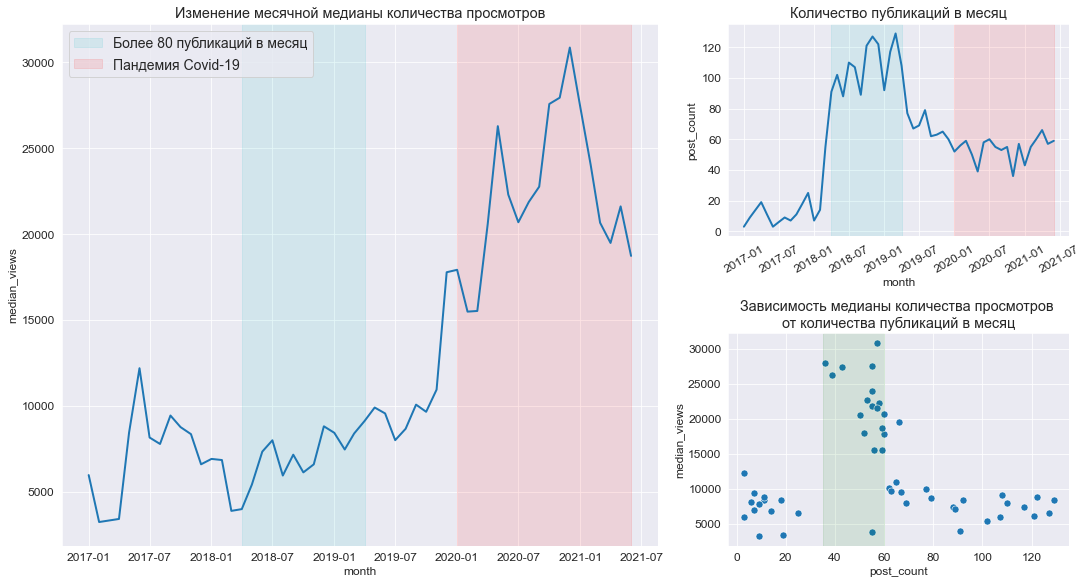

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(15, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[3.5, 2])
f_ax1 = fig.add_subplot(gs[:, 0])
f_ax2 = fig.add_subplot(gs[0, 1])
f_ax3 = fig.add_subplot(gs[1, 1])

f_ax1.set_title('Изменение месячной медианы количества просмотров')
sns.lineplot(data=metrics_by_mon, x='month', y='median_views', ax=f_ax1, lw=2)
f_ax1.axvspan(date(2018, 4, 1), date(2019, 4, 1), alpha=0.1, color='c', label='Более 80 публикаций в месяц')
f_ax1.axvspan(date(2020, 1, 1), posts_df.month.max(), alpha=0.1, color='r', label='Пандемия Covid-19')
f_ax1.legend(fontsize=14)

f_ax2.set_title('Количество публикаций в месяц')
sns.lineplot(data=views_per_mon, x='month', y='post_count', ax=f_ax2, lw=2)
f_ax2.axvspan(date(2020, 1, 1), posts_df.month.max(), alpha=0.1, color='r')
f_ax2.axvspan(date(2018, 4, 1), date(2019, 4, 1), alpha=0.1, color='c')
f_ax2.tick_params(axis='x', rotation=30)


f_ax3.set_title('Зависимость медианы количества просмотров\nот количества публикаций в месяц')
sns.scatterplot(data=metrics_by_mon[['month', 'median_views']].merge(views_per_mon, on='month'), 
                x='post_count', y='median_views', ax=f_ax3, s=50)
f_ax3.axvspan(35, 60, alpha=0.1, color='g')

plt.show()

Судя по графику выше, аудитория паблика значительно увеличилась к декабрю 2019 года, т.е. еще до начала пандемии. Но спустя год медиана увеличилась более, чем в полтора раза:

In [21]:
metrics_by_mon[metrics_by_mon.month.isin([date(2019, 12, 1), date(2020, 12, 1)])].iloc[:, :2]

,month,median_views
34,2019-12-01,17780.5
46,2020-12-01,30865.0


 Таким образом, пандемия оказала заметное влияние на рост интереса к курсам Skillbox и, соответственно, на расширение аудитории паблика Skillbox Вконтакте. Остается убедиться, что и остальные количественные характеристики вовлеченности пользователей (лайки, комментарии и.т.д.) выросли после начала пандемии. \
 Медианное количество просмотров снизилось к середине 2021 года. Это может быть связано как со снижением ажиотажа вокруг онлайн-обучения, так и с ростом популярности других платформ, вроде Инстаграм, Телеграм (снятие блокировки Телеграм произошло в июне 2020 года).

Примечательно, что количество публикаций в месяц не связано с количеством просмотров. Период, когда на стене паблика ежемесячно появлялось более 80 публикаций, выделен голубым цветом. В правом нижнем углу дополнительно представлен график, где по оси *x* отложено количество постов в месяц, а по оси *y* - месячная медиана количества просмотров. Очевидно, явной зависимости между этими двумя показателями нет. Возможно, есть определенное количество публикаций в месяц, в нашем случае 35-60 публикаций, которое обеспечивает нормальное количество просмотров. Можно предположить, что если постов слишком мало, пользователи теряют интерес к паблику (это может отражаться на количестве лайков, репостов и комментариев), если посты публикуются часто, паблик становится чересчур "назойливым", и подписчики опять же теряют интерес (например, могут исключить пуликации паблика из своей новостной ленты).

Прежде чем анализировать влияние пандемии на остальные характеристики вовлеченности пользователей, посмотрим, как эти характеристики влияют друг на друга:

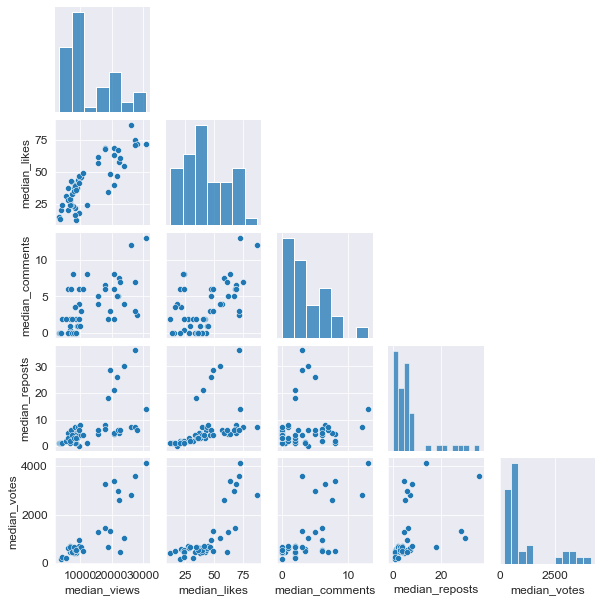

In [22]:
sns.pairplot(data=metrics_by_mon.iloc[:, 1:], corner=True, height=1.7)
plt.show()

Количество лайков и голосов в опросах практически линейно зависят от количества просмотров, при этом зависимость количества голосов от количества лайков похожа на экспоненциальную.\
Количество комментариев и репостов слабо связаны с остальными характеристиками, но голоса в опросах, отчасти, положительно влияют на количество комментариев.

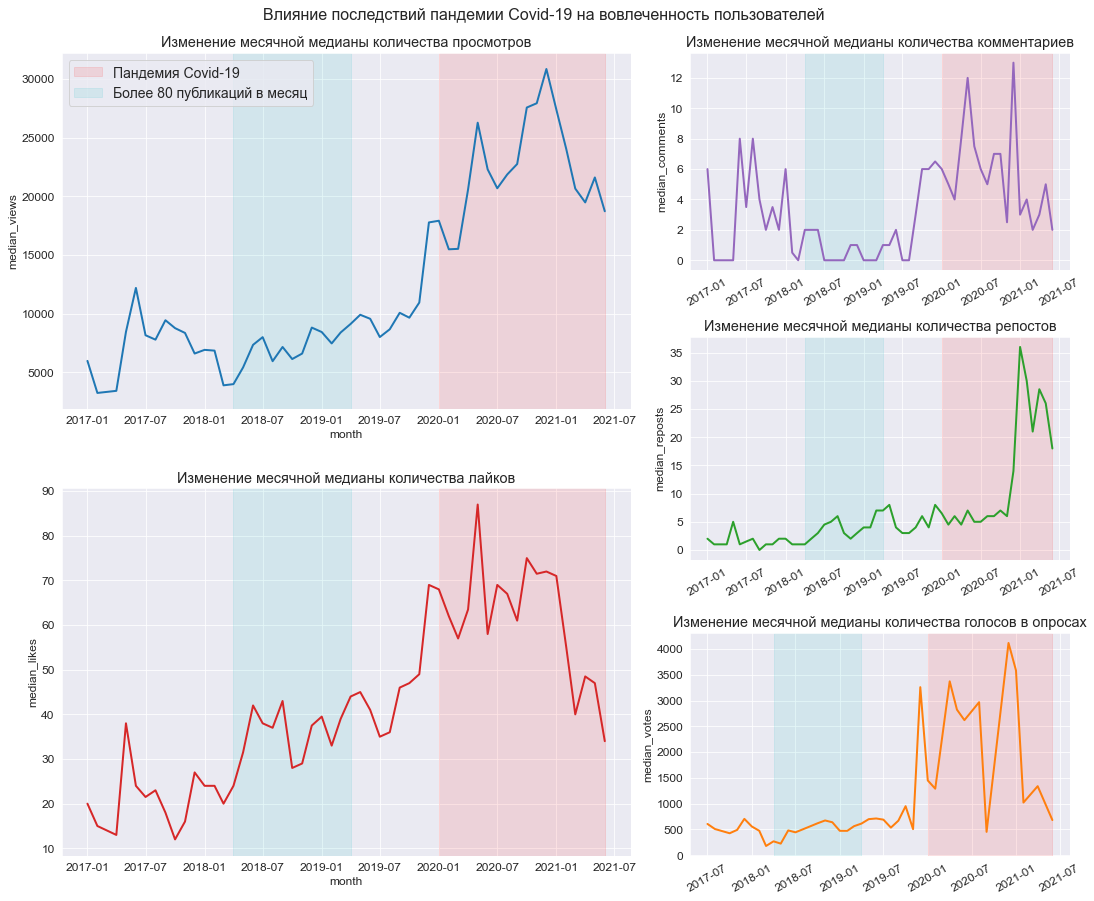

In [23]:
fig = plt.figure(constrained_layout=True, figsize=(15, 12))
gs = fig.add_gridspec(6, 6, width_ratios=[6, 6, 6, 4, 4, 4])
ax1 = fig.add_subplot(gs[:3, :3])
ax2 = fig.add_subplot(gs[3:, :3])
ax3 = fig.add_subplot(gs[:2, 3:])
ax4 = fig.add_subplot(gs[2:4, 3:])
ax5 = fig.add_subplot(gs[4:, 3:])
axes = [ax1, ax2, ax3, ax4, ax5]

plt.suptitle('Влияние последствий пандемии Covid-19 на вовлеченность пользователей', fontsize=16, y=1.03)
title_dict = {col: [word, c] for col, word, c in zip(metrics_by_mon.columns[1:], 
                                                     ['просмотров', 'лайков', 'комментариев', 'репостов', 'голосов в опросах'], 
                                                     ['tab:blue', 'tab:red', 'tab:purple', 'tab:green', 'tab:orange'])}


for ax, param in zip(axes, metrics_by_mon.columns[1:]):
    ax.set_title(f'Изменение месячной медианы количества {title_dict.get(param)[0]}')
    if ax != ax5:
        sns.lineplot(data=metrics_by_mon, x='month', y=param, ax=ax, color=title_dict.get(param)[1], lw=2)
    else:
        sns.lineplot(data=metrics_by_mon.dropna(), x='month', y=param, ax=ax, color=title_dict.get(param)[1], lw=2)
    ax.axvspan(date(2020, 1, 1), posts_df.month.max(), alpha=0.1, color='r', label='Пандемия Covid-19')
    ax.axvspan(date(2018, 4, 1), date(2019, 4, 1), alpha=0.1, color='c', label='Более 80 публикаций в месяц')

for ax in axes[2:]:
    ax.set_xlabel(None)
    ax.tick_params(axis='x', rotation=30)

ax1.legend(fontsize=14)

plt.show()

Хотя в течение первого года пандемии количество лайков увеличилось, в 2021 году оно снизилось примерно до уровня 2019 года, так же, как и количество просмотров.

Количество комментариев - самая непостоянная характеристика, которая слабо зависит от всех остальных. Тем не менее, после начала пандемии, медианное количество комментариев в месяц ни разу не упало ниже 2. Кроме того, максимальные значения медианы относятся к периоду пандемии.

Кажется, начало пандемии не оказало влияния на репосты публикаций паблика. Медиана количества репостов резко выросла в конце 2020 -  начале 2021 года. До декабря 2020 года медианное количество репостов не превышало 10, в январе 2021 года оно увеличилось до 36 и не опускалось ниже 15 до конца рассматриваемого периода. Таким образом, количество репостов увеличилось тогда, когда остальные показатели вовлеченности пользователей снизились, и не кажется, что этот рост напрямую связан с последствиями пандемии. Возможно, в 2021 году паблик стал чаще запускать конкурсы, связанные с репостами.

Вовлеченность пользователей в опросы была невысокой до декабря 2019 года; в 2020 году было значительно больше месяцев с высокой медианой количества голосов, например, медианное количество голосов с марта по август 2020 года включительно не опускалось ниже 2500. Значительная просадка медианы произошла в сентябре 2020 года. В 2021 году вовлеченность пользователей в опросы упала вместе с количеством просмотров и лайков.

Высокая частота публикаций, возможно, отрицательно влияет на количество комментариев пользователей: период, когда посты в паблике публиковались чаще всего, совпадает с периодом низких медианных значений количества комментариев. На остальные показатели вовлеченности частота публикаций явным образом не влияет.

**Вывод**

Пандемия Covid-19 несомненно привела к тому, что вовлеченность пользователей паблика Skillbox ВКонтакте выросла. Значительный скачок параметров вовлеченности произошел в первый год пандемии, со временем количество просмотров, лайков и проч. стало уменьшаться, и, возможно, будет падать и дальше. Так выглядит процентное изменение всех характеристик за последние 3 года (по сравнению с 2018 годом):

In [24]:
params_by_year = posts_df.groupby(posts_df.date_and_time.apply(get_year))\
[['views', 'likes', 'comments', 'reposts', 'votes']].median().reset_index()\
.rename(columns={'date_and_time': 'year'}).set_index('year')

params_by_year[params_by_year.index > 2017].apply(lambda x: x*100/params_by_year.loc[2018] - 100, axis=1)

,views,likes,comments,reposts,votes
year,,,,,
2018,0.000000,0.000000,0.0,0.000000,0.000000
2019,38.327552,23.529412,0.0,66.666667,40.386803
2020,244.073292,97.058824,500.0,100.000000,449.943117
2021,227.107525,33.823529,200.0,733.333333,194.197952


Поддерживать нормальную вовлеченность пользователей может быть проще, если определить предпочтительное время публикации постов. Кроме этого, можно анализировать фидбэк пользователей об отдельных рубриках паблика. 

## Предпочтительное время публикации

Определим, в какой промежуток дня публикуются записи на стене сообщества:

In [25]:
posts_df['date_and_time'].apply(lambda x: x.time()).apply([min, max])

min    08:30:00
max    23:16:09
Name: date_and_time, dtype: object

Записи публикуются примерно с 8:30 до 23:15. Для удобства расширим промежуток времени до `8:00 - 00:00` и разобьем все посты на 4 равных по времени группы:
- записи, опубликованные утром, с 8:00 до 12:00,
- записи, опубликованные днем, с 12:00 до 16:00,
- записи, опубликованные вечером, с 16:00 до 20:00,
- записи, опубликованные поздним вечером, с 20:00 до 00:00.

In [26]:
from datetime import time
posts_df['time_of_day'] = ['morning \n8:00-12:00' if time(8, 0, 0) <= t < time(12, 0, 0)
                          else 'afternoon \n12:00-16:00' if time(12, 0, 0) <= t < time(16, 0, 0) 
                          else 'evening \n16:00-20:00' if time(16, 0, 0) <= t < time(20, 0, 0)
                          else 'late evening \n20:00-00:00' for t in posts_df.date_and_time.apply(lambda x: x.time())]
posts_df.head()

,date_and_time,text,views,likes,comments,reposts,votes,month,time_of_day
152,2021-06-30 18:19:40,"Если вы опустили руки, повесили нос и упали ду...",67356.0,31,19,15,NaN,2021-06-01,evening \n16:00-20:00
153,2021-06-30 15:30:29,Часто люди работают как лампочки: либо по щелч...,15997.0,34,15,9,NaN,2021-06-01,afternoon \n12:00-16:00
154,2021-06-30 13:28:07,"Получите шанс на сотрудничество со Skillbox, P...",14333.0,17,0,3,NaN,2021-06-01,afternoon \n12:00-16:00
155,2021-06-29 20:29:56,Можно ли получить высшее образование полностью...,15252.0,36,11,22,NaN,2021-06-01,late evening \n20:00-00:00
156,2021-06-29 18:56:23,Не учитесь на чужих ошибках — учитесь на чужих...,13554.0,19,0,4,NaN,2021-06-01,evening \n16:00-20:00


Посчитаем, сколько постов было опубликовано в различные периоды дня с 2017 по 2021 год:

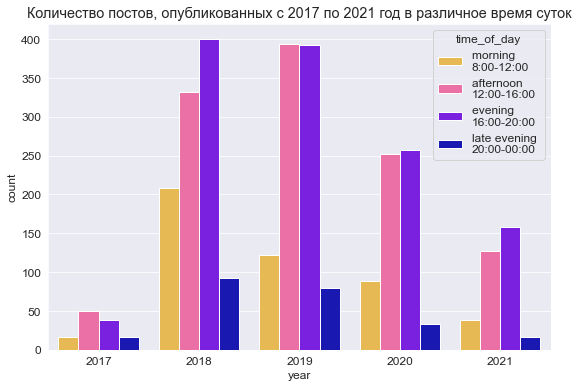

In [27]:
p_count_time = posts_df.groupby([posts_df.date_and_time.apply(get_year), 'time_of_day'])['views'].count()\
.reset_index().rename(columns={'date_and_time': 'year', 'views': 'count'})

plt.figure(figsize=(9, 6))
plt.title('Количество постов, опубликованных с 2017 по 2021 год в различное время суток')
sns.barplot(data=p_count_time, x='year', y='count', hue='time_of_day', palette='gnuplot2_r', 
            hue_order=['morning \n8:00-12:00', 'afternoon \n12:00-16:00', 'evening \n16:00-20:00', 'late evening \n20:00-00:00'])
plt.show()

Большая часть записей публикуется на стене сообщества днем и вечером с 12:00 до 20:00. 

Сгруппируем посты по годам и промежуткам времени, найдем медиану для каждой группы и построим барплот для каждого параметра вовлеченности:

In [28]:
posts_by_time = posts_df.groupby([posts_df.date_and_time.apply(get_year), 'time_of_day'])\
[['views', 'likes', 'comments', 'reposts', 'votes']].median().stack(dropna=False).reset_index()\
.rename(columns={'date_and_time': 'year', 'level_2': 'parameter', 0: 'median_count'})
posts_by_time.head()

,year,time_of_day,parameter,median_count
0,2017,afternoon \n12:00-16:00,views,7188.0
1,2017,afternoon \n12:00-16:00,likes,21.5
2,2017,afternoon \n12:00-16:00,comments,2.0
3,2017,afternoon \n12:00-16:00,reposts,1.0
4,2017,afternoon \n12:00-16:00,votes,539.0


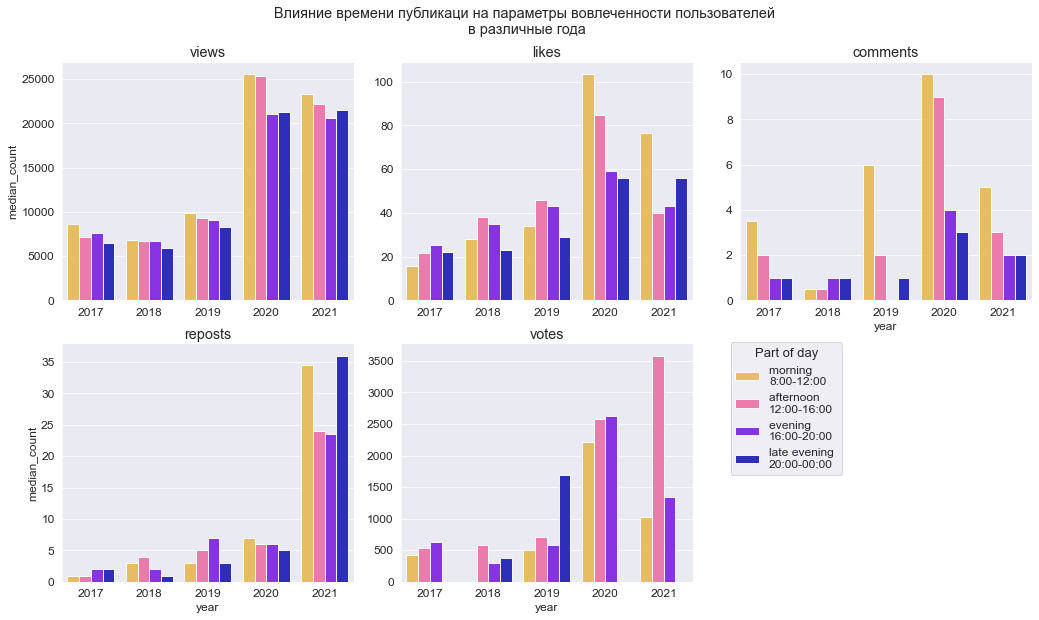

In [29]:
plots = sns.catplot(data=posts_by_time, x='year', y='median_count', hue='time_of_day', kind='bar', col='parameter', col_wrap=3, 
            hue_order=['morning \n8:00-12:00', 'afternoon \n12:00-16:00', 'evening \n16:00-20:00', 'late evening \n20:00-00:00'], 
            sharex=False, sharey=False, palette='gnuplot2_r', alpha=0.9, legend=False, height=4, aspect=1.2)

for i, ax in enumerate(plots.axes):
    ax.set_title(posts_by_time.parameter.unique()[i])
plt.suptitle('Влияние времени публикаци на параметры вовлеченности пользователей\nв различные года', x=0.5, y=1.05)
plt.legend(loc=7, bbox_to_anchor=(1.53, 0.73), title='Part of day', title_fontsize=13)
plt.show()

Судя по графику выше, от времени, в которое публикации появляются на стене паблика, меньше всего зависит количество просмотров: медианные годовые количества просмотров утренних, дневных и вечерних публикаций отличаются не очень сильно. Но разница все-таки есть: в последние три года посты, опубликованные утром до 12:00 и днем до 16:00 часов, успевает просмотреть большее количество человек.

В последние 2 года больше всего лайков собирают посты, опубликованные утром до 12:00. До этого лайки чаще ставили постам, опубликованным с 12:00 до 20:00.

Больше всего комментариев люди оставляют под утренними и дневными постами, только 2018 год стал исключением из этого правила. Стоит учесть, правда, что в этот год количество комментариев было самым маленьким в рамках выбранного периода.

До 2021 года трудно выявить какую-то зависимость количества репостов от времени публикации. В 2021 году, когда медианное количество репостов резко выросло относительно предыдущих лет, пользователи репостили записи, опубликованные утром до 12:00 и вечером после 20:00, чаще остальных: примерно 35 репостов утром и поздно вечером против 24 в середине дня.

Для количества голосов в опросах трудно выявить явную зависимость от времени публикации опроса: например, в 2019 году больше всего голосов собирали опросы, опубликованные поздно вечером; в 2020 году поздних вечерних опросов не было, а утренние опросы собирали чуть меньше голосов, чем те, что были опубликованы с 12:00 до 20:00 часов; в 2021 году опросы, публикуемые днем с 12:00 до 16:00 вовлекали значительно больше пользователей, чем утренние и вечерние, при том, что вовлеченность пользователей в 2021 году упала. \
Если требуется выявить предпочтительное время публикации опросов, я бы рекомендовала делать ставку на статистику последних двух лет и публиковать  опросы в дневное время (с 12:00 до 16:00), когда, кроме прочего, выше количество просмотров, лайков и комментариев, либо попробовать публиковать опросы после 20:00, основываясь на успехе опросов 2019 года, которые запускали поздно вечером.

**Вывод**

Исходя из медианных значений параметров вовлеченности за последние два года, самое предпочтительное время для публикации записей - это первая половина дня, с 8:00 до 16:00. Паблик Skillbox в основном публикует записи с 12:00 до 20:00. Я бы рекомендовала публиковать больше записей до 12:00 и меньше после 16:00, т.е. немного перераспределить публикацию постов, и посмотреть, как это отразится на вовлеченности пользователей.

## Предпочтительные дни публикации

Мы выяснили, что время суток, в которое публикуются записи, влияет на вовлеченность пользователей. А имеет ли значение, в какой день, будний или выходной, публикуются записи? Сгруппируем записи по годам и дням недели и проверим.

In [30]:
# список дней недели
weekdays = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
posts_df['weekday'] = [weekdays[n] for n in posts_df.date_and_time.apply(lambda x: x.weekday())]

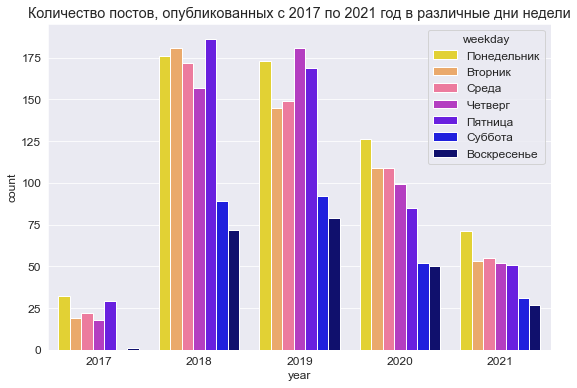

In [31]:
p_count_wkday = posts_df.groupby([posts_df.month.apply(get_year), 'weekday'])\
['views'].count().reset_index().rename(columns={'month': 'year', 'views': 'count'})

plt.figure(figsize=(9, 6))
plt.title('Количество постов, опубликованных с 2017 по 2021 год в различные дни недели')
plot = sns.barplot(data=p_count_wkday, x='year', y='count', hue='weekday', palette='gnuplot2_r', 
                  hue_order=weekdays)
plt.show()

Большая часть записей публиковалась в будние дни, при чем в понедельник чаще, чем в остальные.

Сгруппируем посты по годам и дням недели, найдем медиану для каждого параметра вовлеченности и построим барплоты:

In [32]:
posts_by_weekday = posts_df.groupby([posts_df.month.apply(get_year), 'weekday'])\
[['views', 'likes', 'comments', 'reposts', 'votes']].median().stack(dropna=False).reset_index()\
.rename(columns={'month': 'year', 'level_2': 'parameter', 0: 'median_count'})
posts_by_weekday.head()

,year,weekday,parameter,median_count
0,2017,Воскресенье,views,3237.0
1,2017,Воскресенье,likes,8.0
2,2017,Воскресенье,comments,0.0
3,2017,Воскресенье,reposts,2.0
4,2017,Воскресенье,votes,NaN


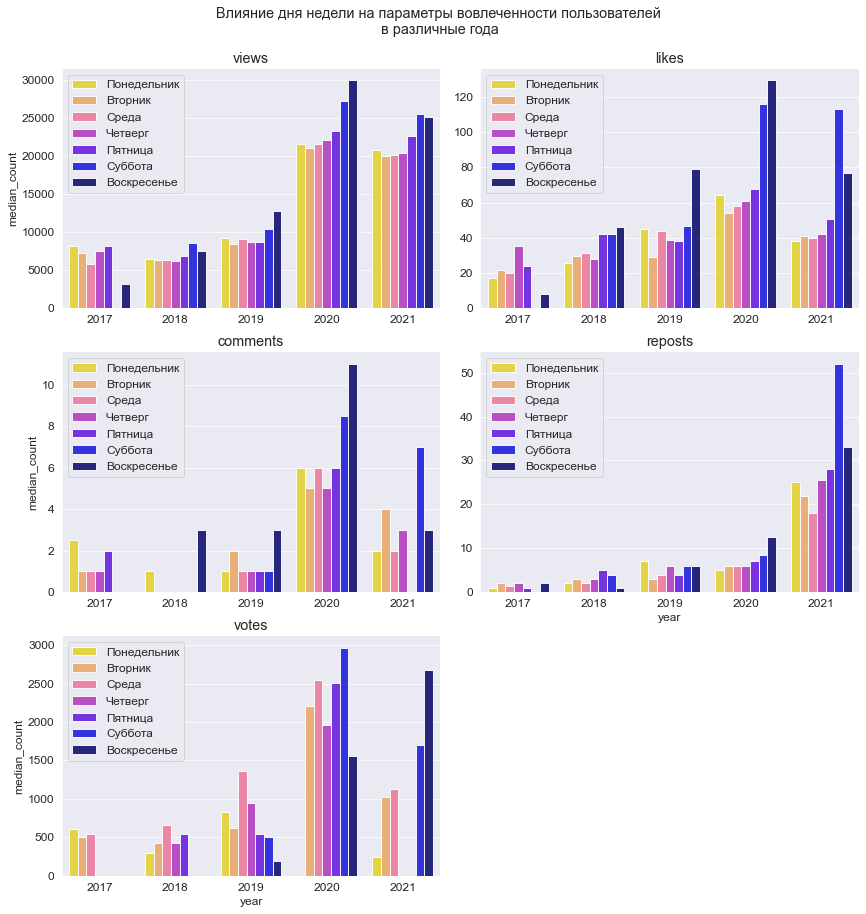

In [33]:
plots = sns.catplot(data=posts_by_weekday, x='year', y='median_count', hue='weekday', kind='bar', col='parameter', col_wrap=2,
                    hue_order=weekdays, sharex=False, sharey=False, palette='gnuplot2_r', alpha=0.9, 
                    legend=False, height=4, aspect=1.5)
plt.suptitle('Влияние дня недели на параметры вовлеченности пользователей\nв различные года', x=0.5, y=1.04)

for i, ax in enumerate(plots.axes):
    ax.legend(loc=2)
    ax.set_title(posts_by_weekday.parameter.unique()[i])

plt.show()

Судя по графикам, в последние три года количество просмотров и лайков было выше в выходные дни.

В 2020 году больше всего комментариев было под постами, опубликованными в выходные, а в 2021 году субботние посты собирали примерно в полтора раза больше комментариев, чем посты, опубликованные в остальные дни недели.

Количество репостов записей паблика в принципе не очень велико, и с 2017 по 2019 год оно практически не зависело от того, в какой день недели опубликована запись. В 2020 году у постов, опубликованных в субботу и воскресенье, репостов было чуть больше, чем у остальных. В 2021 году больше всего репостов набирали посты, опубликованные в субботу.

Сделать вывод относительно предпочтительного дня недели для опросов труднее: только в 2019 году опросы публиковались во все дни недели. В 2017, 2018 годах опросы не публиковались в выходные дни, в 2020 - в понедельник, а в 2021 - в четверг и пятницу.

**Вывод**

В целом, можно сказать, что вовлеченность пользователей выше в выходные дни (сильнее всего это отражается на количестве лайков), поэтому я бы рекомендовала чаще публиковать записи в субботу и воскресенье.
***

## Направления и рубрики паблика

При помощи регулярных выражений выделим хэштеги для каждого поста. `tags_list` будет содержать списки хэштегов для каждого поста в датафрейме, а список `all_tags` - все встречающиеся хэштеги. Первый список можно включить в датафрейм в качестве отдельной колонки, а с помощью второго посмотреть, какие хэштеги встречаются чаще всего, и выделить несколько регулярных рубрик.

In [34]:
reg_expr = r'#{1}\w+'
reg_expr_compiled = re.compile(reg_expr)

tags_list = []
all_tags = []

for raw_text in posts_df.text:
    tags = reg_expr_compiled.findall(raw_text.lower())
    tags_list.append(tags)
    all_tags.extend(tags)

Добавим в датафрейм колонку с хэштегами и выведем список хэштегов, которые встречаются в паблике хотя бы 10 раз:

In [35]:
posts_df['tags'] = tags_list
common_tags = (pd.Series(all_tags).value_counts() >= 10).sum()
pd.Series(all_tags).value_counts().head(common_tags)

#read                           370
#skillbox_дизайн                366
#статья_skillbox                339
#skillbox_маркетинг             211
#marketing                      200
#design                         196
#code                           190
#в_закладки_skillbox            167
#skillbox_программирование      152
#collections                    126
#расписание_skillbox            102
#skillbox_управление             92
#s2jsjk                          75
#sje5lq                          54
#management                      53
#team                            51
#friday_typeface                 50
#calendar                        50
#лекторий_skillbox               48
#skillbox_вдохновляет            43
#answer                          43
#reviews                         43
#y0fjdx                          42
#skillbox                        40
#weekbook                        37
#history                         37
#designbattle                    34
#анонс_skillbox             

Чаще всего в постах встречаются хэштеги, содержащие название направления (`#marketing`, `#design`, `#code`, `#skillbox_дизайн`, `#skillbox_управление` и т.д.), хэштеги для статей или подборок статей и видео (`#read`, `#статья_skillbox`, `#collections`, `#в_закладки_skillbox`) и расписания (`#расписание_skillbox`).

Судя по частоте встречающихся хэштегов, основными направлениями в паблике являются *дизайн, маркетинг, программирование и управление*. Можно оценить относительную популярность каждого из этих направлений, проанализировав показатели вовлеченности пользователей. Хочется посмотреть, на то какие направления популярны в последнее время, поэтому выберем посты только за 2020 и 2021 год.

Хэштегами также отмечены различные рубрики паблика. Интересно проанализировать несколько рубрик разного формата, например, подборку, опрос "вариант А против варианта В" и игру. Для этого я выбрала рубрики "Шрифт недели от Skillbox" и "Шрифты_Skillbox" (`#friday_typeface`, `#шрифты_skillbox`), "Дизайн-битва" (`#designbattle`, `#design_battle_skillbox`) и "Игра по управлению" (`#игра_skillbox_по_управлению`).

### Популярность направлений в 2020 и 2021 году

Отфильтруем все посты, не содержащие хэштегов и составим список хэштегов, относящих пост к тому или иному направлению:

In [36]:
tagged_posts = posts_df[posts_df.tags.apply(bool)].copy()
field_tags_list = ['#skillbox_дизайн', '#skillbox_программирование', '#skillbox_управление', '#skillbox_маркетинг', 
                   '#design', '#management', '#code', '#marketing']

Развернем списки хэштегов и сформируем серию, содержащую индекс поста и соответствующий хэштег:

In [37]:
indexes = []
tags = []

for i in tagged_posts.tags.index:
    for tag in tagged_posts.tags[i]:
        indexes.append(i)
        tags.append(tag)

tags_series = pd.Series(tags, index=indexes)
tags_series.head(6)

152                       #skillbox
153                 #skillbox_анонс
154                 #skillbox_анонс
155    #высшее_образование_skillbox
155                #статья_skillbox
156            #skillbox_управление
dtype: object

Теперь мы можем использовать серию `tags_series` как шаблон для выбора нужных постов.\
Оставим только те теги, которые относят пост к одному из направлений и выделим информацию об этих постах с помощью функции merge(). Сохраним результат в датафрейм `fields_df`.

In [38]:
field = tags_series[tags_series.isin(field_tags_list)].copy().rename('field')
fields_df = tagged_posts.merge(field, how='right', left_index=True, right_index=True)

Некоторые посты могут относиться сразу к нескольким направлениям, в этом случае они дублируются в датафрейме. Пример:

In [39]:
fields_df[fields_df.index == 715]

,date_and_time,text,views,likes,comments,reposts,votes,month,time_of_day,weekday,tags,field


Выберем посты, относящиеся к 2020 - 2021 годам, а также изменим колонку field, чтобы она содержала не хэштег, а только название направления:

In [40]:
fields_df['field'] = fields_df.field.apply(lambda x: x[1:].split('_')[-1])
fields_df_20 = fields_df[fields_df.date_and_time.apply(get_year) >= 2020].copy()
fields_df_20.head(3)

,date_and_time,text,views,likes,comments,reposts,votes,month,time_of_day,weekday,tags,field
156,2021-06-29 18:56:23,Не учитесь на чужих ошибках — учитесь на чужих...,13554.0,19,0,4,NaN,2021-06-01,evening \n16:00-20:00,Вторник,[#skillbox_управление],управление
162,2021-06-26 12:43:21,Языков программирования год от года становится...,26934.0,70,7,47,NaN,2021-06-01,afternoon \n12:00-16:00,Суббота,[#skillbox_программирование],программирование
163,2021-06-25 18:30:17,"Cделать видео для поста, сторис или рекламы мо...",17028.0,55,0,71,NaN,2021-06-01,evening \n16:00-20:00,Пятница,"[#skillbox_маркетинг, #статья_skillbox]",маркетинг


Посмотрим на количество постов, опубликованных для каждого направления за последние полтора года:
    

In [41]:
fields_df_20.field.value_counts()

дизайн              225
маркетинг           151
программирование    104
управление           51
Name: field, dtype: int64

Можно отметить, что как минимум последние полтора года для обозначения направлений не используются англоязычные хэштеги code, design, marketing и management. С января 2020 по июль 2021 больше всего постов опубликовано по направлению `дизайн`, меньше всего - по `управлению`. Сгруппируем посты по направлениям и посмотрим на медианы показателей вовлеченности для каждой группы:

In [42]:
fields_df_20.groupby('field')[['views', 'likes', 'comments', 'reposts', 'votes']].median()

,views,likes,comments,reposts,votes
field,,,,,
дизайн,23571.0,86.0,5.0,12.0,2620.0
маркетинг,22810.0,63.0,5.0,13.0,241.0
программирование,21831.0,60.0,7.0,10.5,1123.0
управление,21960.0,68.0,2.0,16.0,NaN


Количества просмотров публикаций по разным направлениям различаются не сильно, посты по дизайну просматривает обычно чуть большее количество пользователей. Если исходить из медианного количества просмотров, лайков и голосов в опросах, то `дизайн` является самым популярным направлением паблика. Примечательно, что несмотря на это, больше всего комментариев оставляют под постами по программированию, а делятся чаще всего постами по управлению. Судя по таблице выше, нельзя сказать, что `управление` значительно отстает по популярности от остальных направлений: медианное количество просмотров и лайков под постами по управлению больше, чем под постами по программированию. При этом за последние полтора года постов по управлению опубликовано примерно в 2 раза меньше, чем по программированию, в 3 раза меньше, чем по маркетингу, и в 4 раза меньше, чем по дизайну. Также за это время в паблике не было ни одного опроса, связанного с управлением.

Для большей наглядности можно отобразить полученную таблицу на графике:

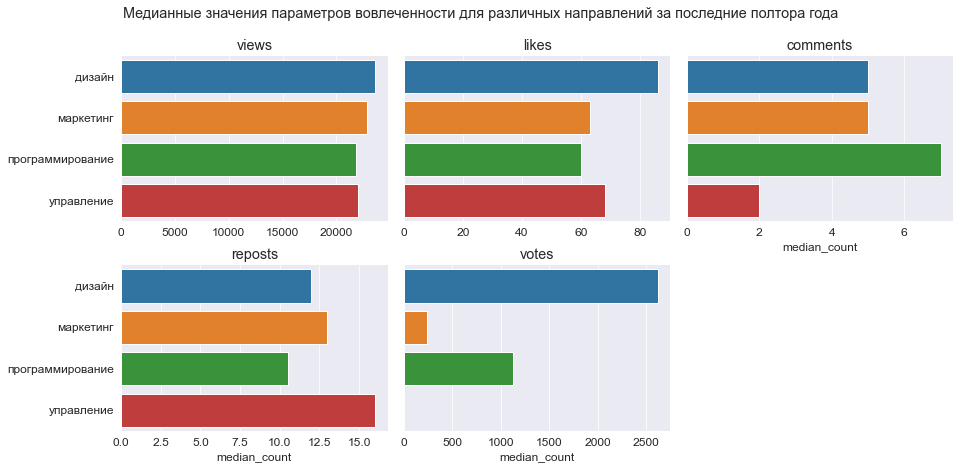

In [43]:
data = fields_df_20.groupby('field')[['views', 'likes', 'comments', 'reposts', 'votes']].median()\
.stack().reset_index().rename(columns={'level_1': 'parameter', 0: 'median_count'})

plots = sns.catplot(data=data, x='median_count', y='field',
                   kind='bar', col='parameter', col_wrap=3, height=3, aspect=1.5, sharex=False)
for i, ax in enumerate(plots.axes):
    ax.set_ylabel(None)
    ax.set_title(data.parameter.unique()[i])

plt.suptitle('Медианные значения параметров вовлеченности для различных направлений за последние полтора года', y=1.05)
plt.show()

### Анализ рубрик
Для анализа было выбрано несколько рубрик разного формата:
- [подборки шрифтов](#Подборки-шрифтов) (`#friday_typeface`, `#шрифты_skillbox`), 
- ["Дизайн-битва"](#Дизайн-битва) (`#designbattle`, `#design_battle_skillbox`),
- ["Игра по управлению"](#Игра-по-управлению) (`#игра_skillbox_по_управлению`).

Используем серию `tags_series` для формирования датафрейма для каждой из этих рубрик.


### Подборки шрифтов
Подборки шрифтов паблика хранятся под двумя основными хэштегами: `#friday_typeface` и `#шрифты_skillbox`. С помощью серии tags_series выберем индексы постов, содержащих эти хэштеги, и сохраним информацию о постах в датафрейм `typeface_df`.

In [44]:
typeface_df = tagged_posts[tagged_posts.index.isin(
    tags_series[tags_series.isin(['#friday_typeface', '#шрифты_skillbox'])].index)].copy()

# выделим основной тег в отдельную колонку
typeface_df['main_tag'] = [t_list[0] for t_list in typeface_df.tags]
typeface_df.head(3)

,date_and_time,text,views,likes,comments,reposts,votes,month,time_of_day,weekday,tags,main_tag
553,2020-11-28 15:23:03,Свежая подборка бесплатных шрифтов! Пополняйте...,29365.0,83,0,17,NaN,2020-11-01,afternoon \n12:00-16:00,Суббота,[#шрифты_skillbox],#шрифты_skillbox
645,2020-09-28 16:21:16,Ищете незаезженный шрифт для заголовка?\nСмотр...,20977.0,72,3,17,NaN,2020-09-01,evening \n16:00-20:00,Понедельник,"[#шрифты_skillbox, #skillbox_дизайн]",#шрифты_skillbox
687,2020-09-03 13:59:04,Освежаем коллекцию шрифтов новой подборкой!\nС...,29268.0,61,16,9,453.0,2020-09-01,afternoon \n12:00-16:00,Четверг,"[#шрифты_skillbox, #skillbox_дизайн]",#шрифты_skillbox


Для начала посмотрим на количество постов и на то, к какому времени относятся посты с двумя разными хэштегами:

In [45]:
typeface_df.groupby('main_tag')['date_and_time'].agg([min, max, 'count'])\
.applymap(get_date)

,min,max,count
main_tag,,,
#friday_typeface,2018-04-06,2019-06-14,50
#шрифты_skillbox,2019-11-24,2020-11-28,10


Временные диапазоны для двух тегов не пересекаются. `#friday_typeface` использовался первым чуть больше года, с апреля 2018 по июнь 2019, всего было опубликовано 50 постов , рубрика под хэштегом `#шрифты_skillbox` длилась в течение года, с ноября 2019 по ноябрь 2020, всего 10 постов. Видимо, одна рубрика сменила другую, при этом изменился не только хэштег, но и содеражние публикаций. Рубрика под тегом `#friday_typeface` имела название "Шрифт недели от Skillbox", а каждый пост, как правило, содержал информацию об одном шрифте. Под тегом `#шрифты_skillbox` публиковались в основном подборки из нескольких шрифтов, а у рубрики не было однозначного названия. Ниже приведены примеры нескольких публикаций с одним и другим тегом.

In [46]:
for i in typeface_df.groupby('main_tag')['text'].head(2).index:
    tag, text = typeface_df.loc[i].main_tag, typeface_df.loc[i].text
    print('\033[1m' + tag + '\033[0m', text, sep='\n', end='\n'*3)

#шрифты_skillbox
Свежая подборка бесплатных шрифтов! Пополняйте свою коллекцию — скачивайте по ссылке и пользуйтесь: https://yadi.sk/d/hQpHr0fRzcP3_w

Все — с кириллицей 👇🏻

★ Stravinsky TRIAL. Автор — шрифтовой дизайнер из Франции Илья Наумов. Он объединил сильный вертикальный контраст знаменитого шрифта XVIII века Didot с формами современных гротесков. В зависимости от окружения Stravinsky может выглядеть сдержанно или, наоборот, свежо и дерзко.

★ Lighthaus. Шрифт разработал дизайнер из США Джерак Дурзан. Элегантные черты и правильные формы делают его идеальным для полиграфии в премиальном стиле. Подходит как для объемных текстов, так и для лаконичных заголовков.

★ Webnar Bold. Работа шрифтового дизайнера из Великобритании Марии Пигулевской. Вдохновленная творчеством типографа Пауля Реннера и, в частности, его Futura, Мария создала универсальный шрифт для печатных и электронных форматов. Отлично смотрится в заголовках. 

#Шрифты_Skillbox


#шрифты_skillbox
Ищете незаезженный шрифт 

Посмотрим, как еще изменилось ведение подборки: как часто, в какие дни недели и в какое время дня публиковались посты.

In [47]:
# частота публикации
pd.concat([
    typeface_df['date_and_time']
    .apply(get_date)
    .diff(periods=-1).apply(lambda x: x.days), # разница между датами публикации постов, идущих друг за другом, в днях
    typeface_df.main_tag], axis=1)\
.groupby('main_tag')['date_and_time'].agg(['median', 'mean', 'min', 'max', 'std']) # статистика времени между публикациями

,median,mean,min,max,std
main_tag,,,,,
#friday_typeface,7.0,8.857143,7.0,21.0,3.433900
#шрифты_skillbox,36.0,53.300000,19.0,163.0,46.135188


In [48]:
# дни недели публикаций
typeface_df.groupby(['main_tag', 'weekday'])['views'].count().reset_index().rename(columns={'views': 'count'})

,main_tag,weekday,count
0,#friday_typeface,Пятница,50
1,#шрифты_skillbox,Воскресенье,2
2,#шрифты_skillbox,Понедельник,1
3,#шрифты_skillbox,Пятница,1
4,#шрифты_skillbox,Среда,3
5,#шрифты_skillbox,Суббота,2
6,#шрифты_skillbox,Четверг,1


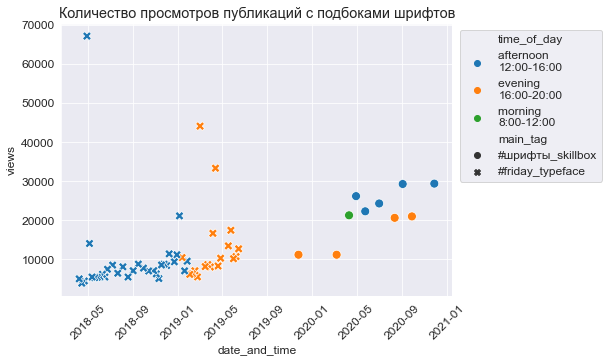

,main_tag,time_of_day,count
0,#friday_typeface,afternoon \n12:00-16:00,32
1,#friday_typeface,evening \n16:00-20:00,18
2,#шрифты_skillbox,afternoon \n12:00-16:00,5
3,#шрифты_skillbox,evening \n16:00-20:00,4
4,#шрифты_skillbox,morning \n8:00-12:00,1


In [49]:
# время публикации
plt.figure(figsize=(7, 5))
plt.title('Количество просмотров публикаций с подбоками шрифтов')
sns.scatterplot(data=typeface_df, x='date_and_time', y='views', hue='time_of_day', style='main_tag', s=80)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc=1, bbox_to_anchor=(1.4, 1))
plt.show()

typeface_df.groupby(['main_tag', 'time_of_day'])['views'].count().reset_index().rename(columns={'views': 'count'})

Посты с тегом `#friday_typeface` чаще всего действительно появлялись на стене паблика раз в неделю и всегда по пятницам. Посты с тегом `#шрифты_skillbox` появлялись на стене паблика гораздо реже, нерегулярно и в разные дни недели. До 2019 года все посты публиковались в дневное время, с 12:00 до 16:00, практически все посты 2019 года - вечером, с 16:00 до 20:00. В 2020 году посты могли быть опубликованы в любое время с 8:00 до 20:00.

Таким образом, регулярная рубрика исчезла, а вместо нее появилась периодическая с похожим содержанием. На основании вовлеченности пользователей, трудно сказать, какой формат предпочтительней, так как в 2020 году, как раз когда рубрика обновилась, показатели вовлеченности пользователей выросли из-за пандемии, а старая рубрика выходила в период, когда посты в паблике публиковались примерно в два раза чаще, чем в последующее время.

Можно попробовать оценить относительную популярность старого и нового формата, сравнив медианное количество просмотров, лайков, репостов и комментариев рубрики с медианными показателями вовлеченности всех постов, опубликованных в те же периоды времени.

In [50]:
typeface_comparison = typeface_df.groupby('main_tag')[['views', 'likes', 'comments', 'reposts']]\
.median().stack().reset_index().rename(columns={'level_1': 'parameter', 0: 'rubric_median'})

old_sample = posts_df[(posts_df.date_and_time < datetime(2019, 6, 14)) & 
                      (posts_df.date_and_time > datetime(2018, 4, 6))][['views', 'likes', 'comments', 'reposts']].median()

new_sample = posts_df[(posts_df.date_and_time < datetime(2020, 11, 28)) & 
                      (posts_df.date_and_time > datetime(2019, 11, 24))][['views', 'likes', 'comments', 'reposts']].median()

comparison_s = pd.concat([old_sample, new_sample]).reset_index(drop=True).rename('all_median')
typeface_comparison = typeface_comparison.merge(comparison_s, left_index=True, right_index=True)
typeface_comparison['rubric_advantage, %'] = round((typeface_comparison['rubric_median'] / typeface_comparison['all_median']) * 100, 2)
typeface_comparison

,main_tag,parameter,rubric_median,all_median,"rubric_advantage, %"
0,#friday_typeface,views,8107.0,7486.0,108.30
1,#friday_typeface,likes,59.0,37.0,159.46
2,#friday_typeface,comments,2.5,1.0,250.00
3,#friday_typeface,reposts,6.0,4.0,150.00
4,#шрифты_skillbox,views,21768.0,21430.0,101.58
5,#шрифты_skillbox,likes,77.5,66.0,117.42
6,#шрифты_skillbox,comments,4.5,6.0,75.00
7,#шрифты_skillbox,reposts,11.0,6.0,183.33


Значения rubric_advantage рассчитаны как отношение медиан по постам рубрики к медианам по всем постам, опубликованным в тот же промежуток времени: $$ rubric\_advantage = \frac{rubric\_median\times100\%}{all\_median}$$ 

Относительно остальных публикаций, рубрика кажется достаточно успешной и в старом и в новом формате. Судя по количеству лайков и просмотров, старый формат рубрики нравился пользователям чуть больше.

С ноября 2020 года постов с тегом `#шрифты_skillbox` больше не было. Проверим, в постах с какими хэштегами встречается слово `шрифт` после этого момента:

In [51]:
posts_since_20_11 = posts_df[posts_df.date_and_time > datetime(2020, 11, 29)]

reg_expr = r'шрифт'
reg_expr_compiled = re.compile(reg_expr)

index_list =  []

for i in posts_since_20_11.index:
    raw_text = posts_since_20_11.text[i]
    tags = reg_expr_compiled.findall(raw_text.lower())
    if tags:
        index_list.append(i)
        
tags_tpfc = posts_since_20_11[posts_since_20_11.index.isin(index_list)].tags
pd.Series(itertools.chain.from_iterable(tags_tpfc)).value_counts()

#skillbox_дизайн             8
#в_закладки_skillbox         2
#skillbox_анонс              2
#skillbox_вдохновляет        1
#readymag                    1
#поиграйтесошрифтами         1
#деньроссийскойпечати        1
#работа_студента_skillbox    1
#конкурс_skillbox            1
#skillbox_инструменты        1
#skillbox_новости            1
dtype: int64

Очевидно, рубрики, которая существовала раньше, больше нет, а информацию, связанную со шрифтами, в постах 2021 года можно найти под хэштегами, перечисленными выше.
****

### Дизайн-битва
Как и в предыдущем случае у нас есть два похожих хэштега `#designbattle` и `#design_battle_skillbox`. Сформируем датафрейм с постами, содержащими эти теги.

In [52]:
designbattle_df = tagged_posts[tagged_posts.index.isin(
    tags_series[tags_series.isin(['#designbattle', '#design_battle_skillbox'])].index)].copy()

# выделим основной тег в отдельную колонку
designbattle_df['main_tag'] = [t_list[0] for t_list in designbattle_df.tags]
designbattle_df.head(3)

,date_and_time,text,views,likes,comments,reposts,votes,month,time_of_day,weekday,tags,main_tag
815,2020-06-27 17:02:46,"Dolby Labs, ведущая компания в области систем ...",26121.0,42,51,0,2620.0,2020-06-01,evening \n16:00-20:00,Суббота,"[#design_battle_skillbox, #skillbox_дизайн]",#design_battle_skillbox
1054,2020-02-07 12:31:03,"Евровидение меняет логотип каждый год, но на э...",17529.0,24,30,0,1647.0,2020-02-01,afternoon \n12:00-16:00,Пятница,"[#design_battle_skillbox, #skillbox_дизайн]",#design_battle_skillbox
1091,2020-01-21 11:01:12,У Xiaomi юбилей — 10 лет! В честь круглой даты...,15038.0,27,55,1,2214.0,2020-01-01,morning \n8:00-12:00,Вторник,"[#design_battle_skillbox, #skillbox_дизайн]",#design_battle_skillbox


In [53]:
designbattle_df.groupby('main_tag')['date_and_time'].agg([min, max, 'count'])\
.applymap(get_date).sort_values(by='min')

,min,max,count
main_tag,,,
#designbattle,2018-09-07,2019-06-11,34
#design_battle_skillbox,2019-06-18,2020-06-27,15


Как и в случае подборки шрифтов, теги не пересекаются во времени. "Старый" хэштег `#designbattle` также появлялся до июня 2019 года, после чего его заменил "новый" `#design_battle_skillbox`, и рубрика продержалась год, до июня 2020. Чем отличались два формата? В старом варианте рубрики пользователям предлагалось из двух вариантов выбрать лучший дизайн сайта, а в новом, за исключением первых трех постов - лучший вариант логотипа. Более подробные сведения об опросах, например вопрос для голосования и распределение голосов, мы можем получить из списка с полной информацией о всех постах `raw_posts_info`:

In [54]:
# Вопросы для первых 10 постов для каждого хэштега

quest_list = []
for i in designbattle_df.groupby('main_tag').tail(10).index:
    question = raw_posts_info[i]['attachments'][-1]['poll']['question']
    quest_list.append(question)
    
pd.concat(
    [designbattle_df.main_tag, 
     pd.Series(quest_list, index=designbattle_df.groupby('main_tag').tail(10).index, name='question')], 
    axis=1, join='inner')

,main_tag,question
1206,#design_battle_skillbox,Какой логотип лучше?
1254,#design_battle_skillbox,Какой логотип Летних Олимпийских игр вам нрави...
1309,#design_battle_skillbox,Какой логотип лучше?
1320,#design_battle_skillbox,Какой логотип лучше?
1338,#design_battle_skillbox,Какой логотип лучше?
1351,#design_battle_skillbox,Какой логотип лучше?
1396,#design_battle_skillbox,Какой логотип лучше?
1468,#design_battle_skillbox,Какой сервис для разработки интерфейсов лучше?
1495,#design_battle_skillbox,Какой мессенджер удобнее с точки зрения дизайна?
1544,#design_battle_skillbox,Чье мобильное приложение удобнее с точки зрени...


Посмотрим, как часто, в какие дни недели и в какое время дня публиковались посты "Дизайн-битвы". Ключевой характеристикой рубрики будем считать количество голосов пользователей, именно его будем выводить на графики. 

In [55]:
# частота публикации
pd.concat([
    designbattle_df['date_and_time']
    .apply(get_date)
    .diff(periods=-1).apply(lambda x: x.days), # разница между датами публикации постов, идущих друг за другом, в днях
    designbattle_df.main_tag], axis=1)\
.groupby('main_tag')['date_and_time'].agg(['median', 'mean', 'min', 'max', 'std'])\
.sort_values(by='median')

,median,mean,min,max,std
main_tag,,,,,
#designbattle,7.0,8.393939,6.0,21.0,3.325464
#design_battle_skillbox,18.0,25.466667,6.0,141.0,33.103445


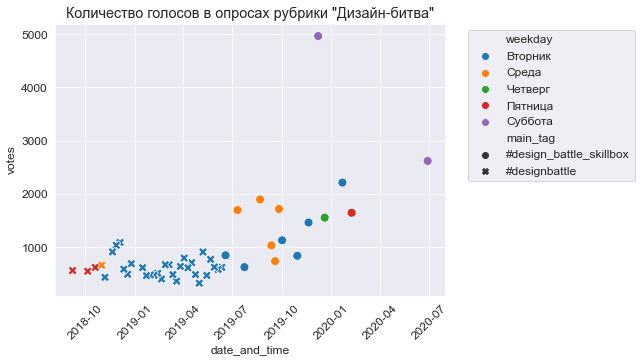

,main_tag,weekday,count
5,#designbattle,Вторник,29
6,#designbattle,Пятница,4
7,#designbattle,Среда,1
0,#design_battle_skillbox,Вторник,6
2,#design_battle_skillbox,Среда,5
3,#design_battle_skillbox,Суббота,2
1,#design_battle_skillbox,Пятница,1
4,#design_battle_skillbox,Четверг,1


In [56]:
# дни недели публикаций

plt.figure(figsize=(7, 5))
plt.title('Количество голосов в опросах рубрики "Дизайн-битва"')
sns.scatterplot(data=designbattle_df, x='date_and_time', y='votes', hue='weekday', style='main_tag', s=80, 
               hue_order=weekdays[1:-1])
plt.tick_params(axis='x', rotation=45)
plt.legend(loc=1, bbox_to_anchor=(1.5, 1))
plt.show()

designbattle_df.groupby(['main_tag', 'weekday'])['views']\
.count().reset_index().rename(columns={'views': 'count'}).sort_values(by=['main_tag', 'count'], ascending=False)

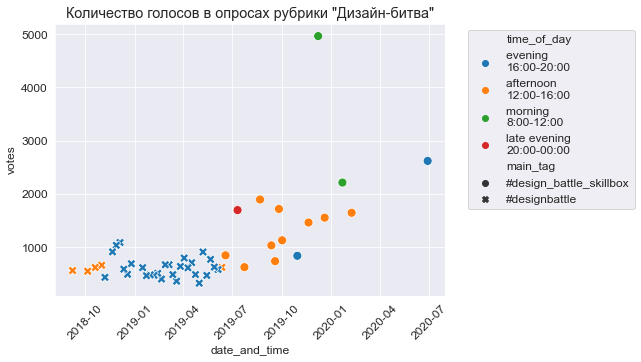

,main_tag,time_of_day,count
0,#design_battle_skillbox,afternoon \n12:00-16:00,10
1,#design_battle_skillbox,evening \n16:00-20:00,2
2,#design_battle_skillbox,late evening \n20:00-00:00,1
3,#design_battle_skillbox,morning \n8:00-12:00,2
4,#designbattle,afternoon \n12:00-16:00,6
5,#designbattle,evening \n16:00-20:00,28


In [57]:
# время публикации
plt.figure(figsize=(7, 5))
plt.title('Количество голосов в опросах рубрики "Дизайн-битва"')
sns.scatterplot(data=designbattle_df, x='date_and_time', y='votes', hue='time_of_day', style='main_tag', s=80)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc=1, bbox_to_anchor=(1.5, 1))
plt.show()

designbattle_df.groupby(['main_tag', 'time_of_day'])['views'].count().reset_index().rename(columns={'views': 'count'})

Как и в предыдущем случае, старый вариант рубрики выходил чаще, регулярнее и в одно и то же время: примерно раз в неделю, всегда по вторникам (кроме первых 4 постов) и всегда в вечернее время с 16:00 до 20:00 (кроме 6 постов). Новый вариант выходил нерегулярно, в основном, в дневное время с 12:00 до 16:00 и в разные дни недели. Несмотря на это, судя по количеству голосов в опросах, новый формат понравился пользователям больше. Я считаю, решающую роль сыграло содержание. Сравнение дизайна сайтов требовало от пользователя дополнительных действий: чтобы оценить дизайн, особенно если пользователь с ним не очень хорошо знаком, нужно было перейти на сайт или зайти в приложение. А чтобы сравнить дизайн логотипов, достаточно было посмотреть на картинку, прикрепленную к посту.\
Можно сделать вывод о том, что большей вовлеченности пользователей легче добиться, если не требовать от них дополнительных действий.

Для анализа рубрик были выбраны хэштеги, которые встречаются в паблике не реже 10 раз. Посмотрим, может быть есть более новый аналог рубрики. Выберем более поздние посты, содержащие опрос и посмотрим на хэштеги:

In [91]:
new_tags = posts_df[(posts_df.votes > 0) 
         & (posts_df.date_and_time > datetime(2020, 6, 28)) 
         & (posts_df.tags.apply(bool))]\
[['date_and_time', 'tags']]
new_tags

,date_and_time,tags
168,2021-06-23 11:30:20,[#skillbox_программирование]
173,2021-06-21 11:23:33,[#skillbox_маркетинг]
421,2021-02-16 11:33:41,"[#дизайн_баттл_skillbox, #skillbox_дизайн]"
474,2021-01-16 13:51:10,"[#дизайн_баттл_skillbox, #skillbox_дизайн]"
486,2021-01-10 14:04:25,"[#дизайн_баттл_skillbox, #skillbox_дизайн]"
521,2020-12-16 18:54:09,"[#дизайн_баттл_skillbox, #skillbox_дизайн]"
528,2020-12-12 13:51:07,[#дизайн_баттл]
687,2020-09-03 13:59:04,"[#шрифты_skillbox, #skillbox_дизайн]"
696,2020-08-29 14:46:26,[#дизайн_баттл]


С конца августа 2020 до февраля 2021 использовались еще два хэштега для обозначения рубрики "Дизайн-битва" - `#дизайн_баттл` и `#дизайн_баттл_skillbox` - всего за это время появилось 6 постов, и с тех пор рубрика больше не выходила. Изменился ли формат рубрики вместе с хэштегами? Посмотрим на вопросы для голосования:

In [92]:
new_tags_indexes = new_tags.iloc[[2,3, 4, 5, 6, 8]].index
quest_list = []
for i in new_tags_indexes:
    question = raw_posts_info[i]['attachments'][-1]['poll']['question']
    print(question)

Какой логотип лучше?
Какой логотип лучше?
Какой логотип круче?
Какой вариант лучше?
Какой логотип лучше?
Какой логотип лучше?


Очевидно, формат не поменялся. Видимо, хэштеги поменялись по другой причине: возможно, нужно было привести все теги паблика к одному стилю, или просто поменялись люди, которые вели стену.

In [64]:
designbattle_df = tagged_posts[tagged_posts.index.isin(
    tags_series[tags_series.isin(
        ['#designbattle', '#design_battle_skillbox', '#дизайн_баттл', '#дизайн_баттл_skillbox'])].index)].copy()

designbattle_df['main_tag'] = [t_list[0] for t_list in designbattle_df.tags]

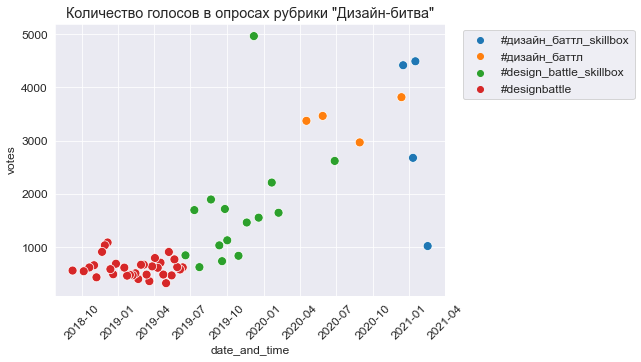

In [65]:
plt.figure(figsize=(7, 5))
plt.title('Количество голосов в опросах рубрики "Дизайн-битва"')
sns.scatterplot(data=designbattle_df, x='date_and_time', y='votes', hue='main_tag', s=80)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc=1, bbox_to_anchor=(1.5, 1))
plt.show()


По графику выше видно, что начиная примерно с апреля 2020 года рубрика выходила под тремя разными хэштегами. Так как формат рубрики не поменялся, а количество голосов выросло в 2020 и упало в начале 2021 года согласно общему тренду, можно лишь заключить, что со временем ведение рубрики стало менее упорядоченным: сначала рубрика стала нерегулярной во времени, а потом стала выходить под разными тегами.
***

### Игра по управлению

Загрузим все посты с нужным хэштегом в датафрейм `management_game_df`

In [66]:
management_game_df = tagged_posts[tagged_posts.index.isin(
    tags_series[tags_series == '#игра_skillbox_по_управлению'].index)].copy()

management_game_df.head(3)

,date_and_time,text,views,likes,comments,reposts,votes,month,time_of_day,weekday,tags
1343,2019-09-15 11:50:16,"Итак, вы выбрали вариант:\n➤ Откажу. Сначала п...",10652.0,17,6,1,196.0,2019-09-01,morning \n8:00-12:00,Воскресенье,"[#игра_skillbox_по_управлению, #рабочая_ситуац..."
1346,2019-09-13 15:00:11,На прошлой неделе вы отстояли свои идеи по мак...,11747.0,22,14,3,602.0,2019-09-01,afternoon \n12:00-16:00,Пятница,"[#игра_skillbox_по_управлению, #рабочая_ситуац..."
1358,2019-09-07 16:50:08,"Итак, вы выбрали ответить:\n\n➤ Вы меня наняли...",9201.0,23,0,1,NaN,2019-09-01,evening \n16:00-20:00,Суббота,"[#игра_skillbox_по_управлению, #рабочая_ситуац..."


Можно заметить, что не все посты содержат опросы. Выведем текст первых двух публикаций, чтобы понять смысл игры:

In [67]:
for i in range(1, 3):
    print(management_game_df.iloc[-i].text, end='\n' + '-'*30 + '\n')
    print('Количество голосов = ', management_game_df.iloc[-i].votes)
    if i == 1:
        print('\n' + '='*127 + '\n')

Представляем игру по управлению проектами. В ней не будет правильных или неправильных ответов, потому что и в реальной жизни их нет. Будет только выбор, который влияет на сюжет игры. Как она закончится — решать вам. 
 
В чем суть игры. Вы — дизайнер, создаете логотипы и проектируете сайты. Вас нашел заказчик, который хочет поручить задачу. Вам нужно пройти все этапы работы над проектом, с которыми сталкивается любой дизайнер на фрилансе. Задача — заслужить доверие клиента, успешно сдать проект и получить деньги. 
 
⬇︎ Поехали ⬇︎ 
 
Клиент написал вам в личные сообщения: 
«Здравствуйте. Нашел ваши контакты на Behance. Понравилось ваше портфолио. Мне нужен дизайн сайта. У меня проект по производству и продаже мебели в Москве. Сколько будут стоить ваши услуги?» 
 
Что вы ответите заказчику?

#Игра_Skillbox_по_управлению #Рабочая_ситуация_Skillbox #Skillbox_управление
------------------------------
Количество голосов =  754.0


Итак, вы выбрали вариант «Попрошу заполнить бриф». Клиент напи

Получается, что формат игры следующий: в первом посте пользователям предлагается выбрать действие, а в следующем оглашается результат голосования, через неделю публикуется пост с новым голосованием и так далее. Проверим, как хорошо соблюдалась эта периодичность.

In [68]:
pd.concat([
    management_game_df.date_and_time.apply(get_date), 
    management_game_df.date_and_time.diff(-1).rename('diff'),
    management_game_df.votes], axis=1)\
.sort_index(ascending=False)

,date_and_time,diff,votes
1478,2019-07-19,NaT,754.0
1475,2019-07-19,0 days 05:57:06,NaN
1459,2019-07-26,6 days 17:10:24,583.0
1457,2019-07-26,0 days 09:14:53,NaN
1446,2019-08-02,6 days 14:55:06,715.0
1444,2019-08-02,0 days 08:45:12,NaN
1430,2019-08-09,6 days 17:26:52,425.0
1427,2019-08-09,0 days 06:12:45,NaN
1408,2019-08-16,6 days 17:55:11,456.0
1403,2019-08-17,1 days 03:56:55,NaN


Действительно, посты с опросами публиковались раз в неделю, а посты с ответами в этот же или на следующий день после каждого опроса. Есть лишь два места, где нарушается регулярность: последний пост содержит опрос и кажется, что не хватает опроса, за которым следует пост 30 августа. В опросе последнего поста пользователям предлагалось оценить игру:

In [69]:
last_post_index = management_game_df.iloc[:1].index[0]
print(raw_posts_info[last_post_index]['attachments'][-1]['poll']['question'])

Понравилась ли вам игра?


Осталось найти недостающий пост. Посмотрим на посты с опросами и опубликованные c 28 по 30 августа включительно:

In [70]:
lost_posts = tagged_posts[(tagged_posts.date_and_time > datetime(2019, 8, 28))
            & (tagged_posts.date_and_time < datetime(2019, 8, 31))
            & (tagged_posts.votes > 0)]
lost_posts

,date_and_time,text,views,likes,comments,reposts,votes,month,time_of_day,weekday,tags
1376,2019-08-30 12:00:14,«На прошлой неделе я не оправдал ожидания клие...,10713.0,11,15,1,477.0,2019-08-01,afternoon \n12:00-16:00,Пятница,"[#играskillbохпоуправлению, #рабочаяситуацияsk..."


Недостающий пост найден, он отличался от остальных хэштегом. Добавим его в датафрейм, а также создадим колонку `type`, в которой будет храниться тип поста - опрос или результат опроса.

In [71]:
management_game_df = management_game_df.append(lost_posts).sort_index()
# последний пост по сути содержит результат к предыдущему опросу, поэтому присвоим ему значение 'result'
management_game_df['type'] = ['result'] + ['poll' if votes > 0 else 'result' for votes in management_game_df.votes.iloc[1:]]

Теперь посмотрим на количество постов, структуру опросов и продолжительность рубрики:

In [72]:
# количество постов
management_game_df.shape[0]

18

In [73]:
# количество вариантов ответа и частота, с которой они встречались
ans_count = []
for i in management_game_df[management_game_df.votes > 0].index:
    ans_count.append(len(raw_posts_info[i]['attachments'][-1]['poll']['answers']))
pd.Series(ans_count).value_counts()

5    5
6    4
3    1
dtype: int64

In [74]:
# продолжительность рубрики
pd.DataFrame(management_game_df.date_and_time.agg([min, max]).apply(get_date))

,date_and_time
min,2019-07-19
max,2019-09-15


In [75]:
# дни недели публикаций
management_game_df.groupby('type').weekday.value_counts().to_frame()

weekday
type   weekday             
poll   Пятница            9
result Пятница            6
       Суббота            2
       Воскресенье        1

Рубрика "Игра по управлению" выходила в течение 2 месяцев, с 19 июля по 15 сентября 2019 года, в основном, по пятницам. Всего было опубликовано 18 постов. В каждом опросе можно было выбрать из 5-6 вариантов ответа.

В какое время публиковались опросы и результаты и повлияло ли это как-то на количество пользователей, которые увидели пост?

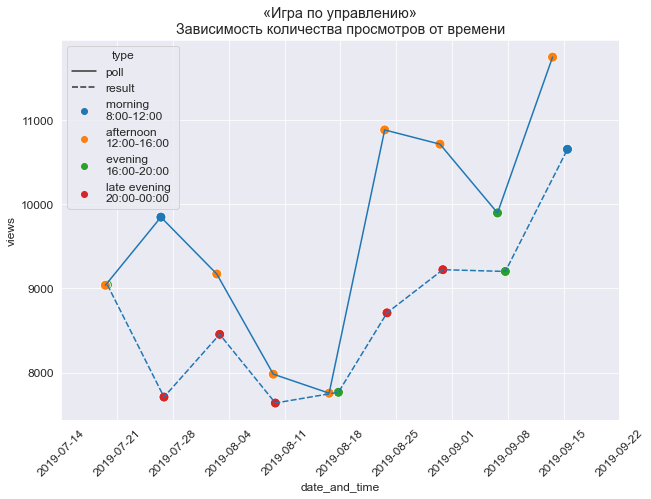

In [76]:
sns.scatterplot(data=management_game_df, x='date_and_time', y='views', hue='time_of_day', s=100)
sns.lineplot(data=management_game_df, x='date_and_time', y='views', style='type', style_order=['poll', 'result'])
plt.title('\u00abИгра по управлению\u00bb\nЗависимость количества просмотров от времени')
plt.xticks(pd.date_range(start=datetime(2019, 7, 14), periods=11, freq='7D'))
plt.tick_params(axis='x', rotation=45)
plt.show()

Большая часть опросов была опубликована днем с 12:00 до 16:00, а большая часть результатов - вечером после 20:00. У опросов, которые публиковались днем, оказалось больше просмотров, чем у результатов, которые публиковались вечером. Это согласуется с предыдущим графиком зависимости годовой меианы просмотров от времени дня публикации. Чтобы результат голосования увидело большее количество людей, возможно, стоило объявлять результат не вечером того же дня, а на следующий день утром или днем или объединять в один пост результат предыдущего голосования со следующим.

Проверим, как изменялась вовлеченность пользователей в опросы: найдем процент пользователей, которые увидели опрос и проголосовали, и построим график зависимости от времени.

In [77]:
management_game_df['voted, %'] = (management_game_df.votes / management_game_df.views) * 100

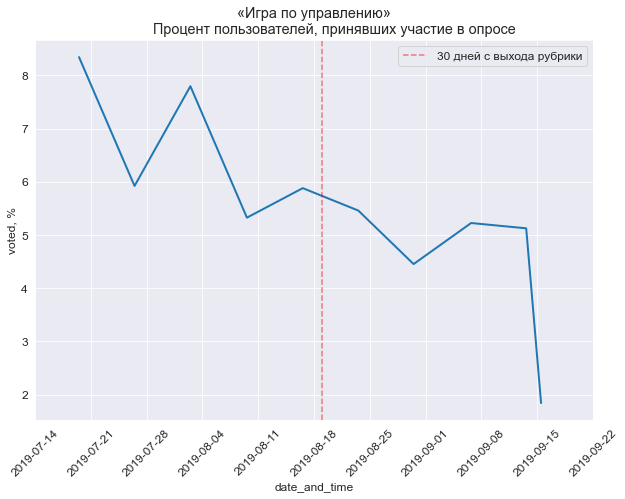

In [78]:
sns.lineplot(data=management_game_df[management_game_df.votes > 0], x='date_and_time', y='voted, %', lw=2)
plt.title('\u00abИгра по управлению\u00bb\nПроцент пользователей, принявших участие в опросе')
plt.axvline(datetime(2019, 8, 19), lw=1.5, ls='--', c='r', alpha=0.5, label='30 дней с выхода рубрики')
plt.xticks(pd.date_range(start=datetime(2019, 7, 14), periods=11, freq='7D'))
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

По сравнению с самым первым постом вовлеченность пользователей в опросы к завершению рубрики снизилась примерно на 2-3%. Можно сказать, что в первый месяц выхода рубрики вовлеченность пользователей в опросы была выше. \
Меньше всего голосов собрал последний опрос, в котором пользователям предлагалось оценить рубрику - относительная вовлеченность составила меньше 2%. Что пользователи в итоге думают о рубрике?


In [80]:
last_post_index = management_game_df.iloc[:1].index[0]
print(raw_posts_info[last_post_index]['attachments'][-1]['poll']['question'], end='\n\n')
for ans in raw_posts_info[last_post_index]['attachments'][-1]['poll']['answers']:
    print('\N{BLACK CIRCLE}', ans['text'], f"- {ans['rate']}%")

Понравилась ли вам игра?

● Очень круто! Давайте еще - 64.29%
● Понравилось, но слегка затянули - 22.96%
● Нет. Игры — это не ваше призвание - 12.76%


Большинству пользователей - 64% - понравилась игра, но значительная часть сочла рубрику затянутой - 23%. Учитывая то, как снизился процент проголосовавших пользователей, рубрика скорее всего действительно затянулась. Возможно, игра была бы успешнее, если бы посты выходили чаще раза в неделю, а продолжительность рубрики была бы меньше. Я думаю, что так было бы проще удержать внимание пользователей, которые уже увидели игру, но при этом она не успела бы им наскучить.